## Introduction

## Data preparation

In [15]:
# !pip install workalendar
# !pip install openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from workalendar.europe import Poland

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


### Loading the dataset

In [10]:
file_path = 'Car_accidents_Poland.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')
df['Date'] = pd.to_datetime(df['Date'],format='%d.%m.%Y')
df.set_index('Date', inplace=True)
df = df.sort_index()
df.index.freq = 'D'
df

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents
Date,,,,,,,
2022-06-15,18116,658,345,277,87,5,95
2022-06-16,15026,677,219,388,65,7,71
2022-06-17,18299,708,345,398,76,10,83
2022-06-18,18769,708,258,404,71,6,72
2022-06-19,16747,739,197,440,59,3,68
...,...,...,...,...,...,...,...
2024-06-14,17103,556,424,237,68,5,73
2024-06-15,17654,599,224,353,56,2,64
2024-06-16,15286,528,237,319,51,5,55


### Adding the exogenous data

In [11]:
df['Day_of_Week'] = df.index.day_name()
day_of_week_columns = pd.get_dummies(df['Day_of_Week'], dtype=float)
df = df.merge(day_of_week_columns, left_index=True, right_index=True)
df

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents,Day_of_Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Date,,,,,,,,,,,,,,,
2022-06-15,18116,658,345,277,87,5,95,Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-06-16,15026,677,219,388,65,7,71,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-06-17,18299,708,345,398,76,10,83,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-18,18769,708,258,404,71,6,72,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-06-19,16747,739,197,440,59,3,68,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,17103,556,424,237,68,5,73,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-15,17654,599,224,353,56,2,64,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-16,15286,528,237,319,51,5,55,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
cal = Poland()
def get_holidays(start_year, end_year):
    holidays = []
    for year in range(start_year, end_year + 1):
        holidays.extend(cal.holidays(year))
    return holidays
holidays = get_holidays(2022, 2024)
additional_holidays = [
    (pd.Timestamp('2024-10-31'), 'Halloween'),
    (pd.Timestamp('2024-11-29'), 'Andrzejki'),
    (pd.Timestamp('2024-05-02'), 'Day before Constitution Day'),
    (pd.Timestamp('2024-06-23'), 'Father\'s Day'),
    (pd.Timestamp('2024-12-24'), 'Christmas Eve'),

    (pd.Timestamp('2023-10-31'), 'Halloween'),
    (pd.Timestamp('2023-11-29'), 'Andrzejki'),
    (pd.Timestamp('2023-05-02'), 'Day before Constitution Day'),
    (pd.Timestamp('2023-06-23'), 'Father\'s Day'),
    (pd.Timestamp('2023-12-24'), 'Christmas Eve'),

    (pd.Timestamp('2022-10-31'), 'Halloween'),
    (pd.Timestamp('2022-11-29'), 'Andrzejki'),
    (pd.Timestamp('2022-05-02'), 'Day before Constitution Day'),
    (pd.Timestamp('2022-06-23'), 'Father\'s Day'),
    (pd.Timestamp('2022-12-24'), 'Christmas Eve')
]
all_holidays = holidays + additional_holidays
index_dates = df.index
valid_holidays = []
for date, name in all_holidays:
    if pd.Timestamp(date) in index_dates:
        valid_holidays.append((pd.Timestamp(date), name))
    preceding_day = pd.Timestamp(date) - pd.Timedelta(days=1)
    if preceding_day in index_dates:
        valid_holidays.append((preceding_day, f'{name} (Eve)'))
holidays_df = pd.DataFrame(valid_holidays, columns=['date', 'name'])
df['is_holiday'] = df.index.to_series().apply(lambda x: x in holidays_df['date'].values).astype(int)
df

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents,Day_of_Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,is_holiday
Date,,,,,,,,,,,,,,,,
2022-06-15,18116,658,345,277,87,5,95,Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2022-06-16,15026,677,219,388,65,7,71,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2022-06-17,18299,708,345,398,76,10,83,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2022-06-18,18769,708,258,404,71,6,72,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2022-06-19,16747,739,197,440,59,3,68,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,17103,556,424,237,68,5,73,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2024-06-15,17654,599,224,353,56,2,64,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2024-06-16,15286,528,237,319,51,5,55,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [23]:
cal = Poland()
cal.holidays(2024)

[(datetime.date(2024, 1, 1), 'New year'),
 (datetime.date(2024, 1, 6), 'Trzech Kroli'),
 (datetime.date(2024, 3, 31), 'Easter Sunday'),
 (datetime.date(2024, 4, 1), 'Easter Monday'),
 (datetime.date(2024, 5, 1), 'Labour Day'),
 (datetime.date(2024, 5, 3), 'Constitution Day'),
 (datetime.date(2024, 5, 19), 'Pentecost Sunday'),
 (datetime.date(2024, 5, 30), 'Corpus Christi'),
 (datetime.date(2024, 8, 15), 'Assumption of Mary to Heaven'),
 (datetime.date(2024, 11, 1), 'All Saints Day'),
 (datetime.date(2024, 11, 11), 'Independence Day'),
 (datetime.date(2024, 12, 25), 'Christmas Day'),
 (datetime.date(2024, 12, 26), 'Boxing Day')]

## Analysis for all Interventions

### Data visualization

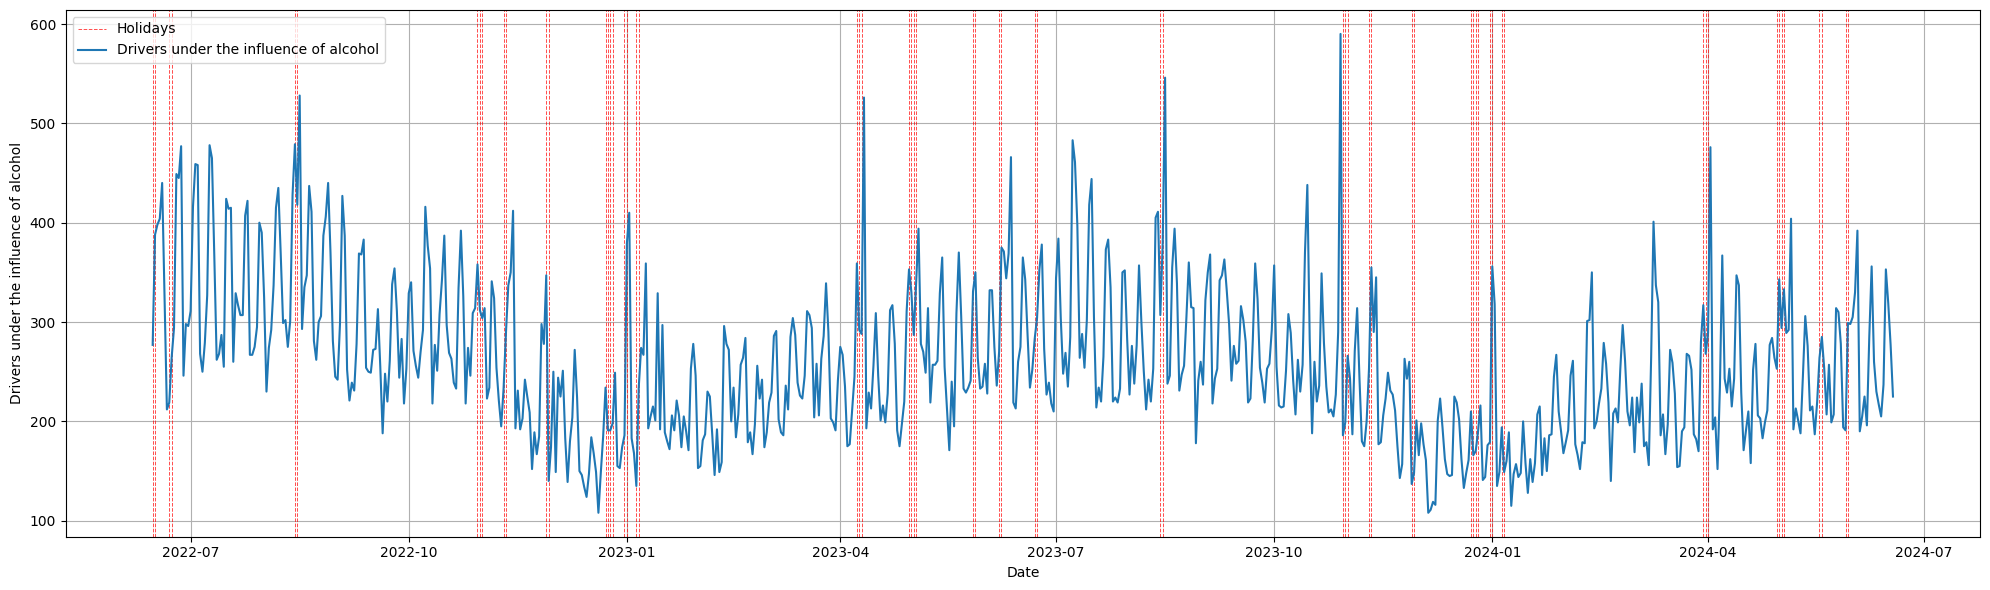

In [25]:
plt.figure(figsize=(20, 6))

holidays = df.index[df['is_holiday'] == True]

plt.axvline(x=holidays[0], color='red', linestyle='--', linewidth=0.7, alpha=0.7, label='Holidays')
# Plot the rest without labels
for holiday in holidays[1:]:
    plt.axvline(x=holiday, color='red', linestyle='--', linewidth=0.7, alpha=0.7, label='_nolegend_')

plt.plot(df.index, df["Drivers_under_the_influence_of_alcohol"], label = 'Drivers under the influence of alcohol')
plt.xlabel('Date')
plt.ylabel('Drivers under the influence of alcohol')
plt.title('')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
# fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20), sharex=True)
# holidays = df.index[df['is_holiday'] == True]
# weekends = df.index[df['is_weekend'] == True]

# for i, col in enumerate(columns):
#     df[col].plot(ax=axes[i], title=col.strip(), legend=False)
#     axes[i].set_ylabel(col.strip())
    
#     # Plot vertical lines on holidays
#     for holiday in holidays:
#         axes[i].axvline(x=holiday, color='r', linestyle='--', lw=1)
      
#     for weekend in weekends:
#         axes[i].axvline(x=weekend, color='g', linestyle='--', lw=1)

# plt.tight_layout()
# plt.show()

### Holt-Winters analysis

### Autoarima analysis

In [ ]:
train = df.iloc[:-7]
test  = df.iloc[-7:]
len(train)

start=len(train)
end=start+len(test)-1
len(train)

In [ ]:
model_all_interventions = auto_arima(
    df["Interventions"],
    exogenous = df[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],
    start_p=0,
    start_q=0,
    max_p=5,
    max_q =5,
    seasonal=True,
    m=7,
    trace = True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)
model_all_interventions.summary()

In [ ]:
model_all_interventions = SARIMAX(train['Interventions'], exog=train[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']], 
                      order=(2,1,0), seasonal_order=(1,0,1,7)).fit() #Best model:  ARIMA(2,1,0)(1,0,1)[7] intercept
model_all_interventions.summary()

In [ ]:
diagnostics = model_all_interventions.plot_diagnostics(figsize=(12, 12))

### Predicting for 1 week

In [ ]:
predictions_all_interventions=model_all_interventions.predict(start=start,exog=test[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],end=end,dynamic=False).rename('SARIMAX')
ax=test['Interventions'].plot(figsize=(14,5))
predictions_all_interventions.plot(legend=True)
for x in test.query('is_holiday==1').index:
    ax.axvline(x=x,color='r')

In [ ]:
mean_absolute_percentage_error(test['Interventions'],predictions_all_interventions)*100

## Analysis for drunken sailors

### Data visualization

In [ ]:
plt.figure(figsize=(20, 6)) 

holidays = df.index[df['is_holiday'] == True]
for holiday in holidays:
    plt.axvline(x=holiday, color='red', linestyle='--', linewidth=0.7, alpha=0.7)

plt.plot(df.index, df["Drivers_under_the_influence_of_alcohol"])
plt.xlabel('Date')
plt.ylabel('Drunken drivers')
plt.title('')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### Holt-Winters analysis

In [38]:
train = df['Drivers_under_the_influence_of_alcohol'].iloc[:-7]
test  = df['Drivers_under_the_influence_of_alcohol'].iloc[-7:]

start=len(train)
end=start+len(test)-1

In [39]:
def forecast_bias(actual_series, pred_series):
    forecast_errors = pred_series - actual_series
    bias = sum(forecast_errors) / sum(actual_series)
    return bias

In [40]:
def Holt_Winters_fit(train_data, test_data, trend_param, seasonal_param, seasonal_period):
    best_fit = ExponentialSmoothing(train_data, initialization_method="estimated", 
                                    seasonal_periods=seasonal_period, 
                                    trend=trend_param, 
                                    seasonal=seasonal_param).fit()
    fcast = best_fit.forecast(len(test_data)) 
    true_values = test_data
    error = forecast_bias(true_values, fcast)
    return error

In [41]:
parameters = [('add', 'add'), ('add', 'mul'), ('mul', 'add'), ('mul', 'mul')]

# Dict for storing forecasts for different parameter combinations
forecasts = {}

# Main loop for fitting and forecasting
for trend_param, seasonal_param in parameters:
    model = ExponentialSmoothing(train, initialization_method="estimated", 
                                 seasonal_periods=7,  # assuming weekly seasonality
                                 trend=trend_param, 
                                 seasonal=seasonal_param).fit()
    fcast = model.forecast(len(test)).rename(r"$\alpha=%s$" % model.model.params["smoothing_level"])
    forecasts[(trend_param, seasonal_param)] = fcast

C:\Users\kbocian\OneDrive - Capgemini\Desktop\University\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


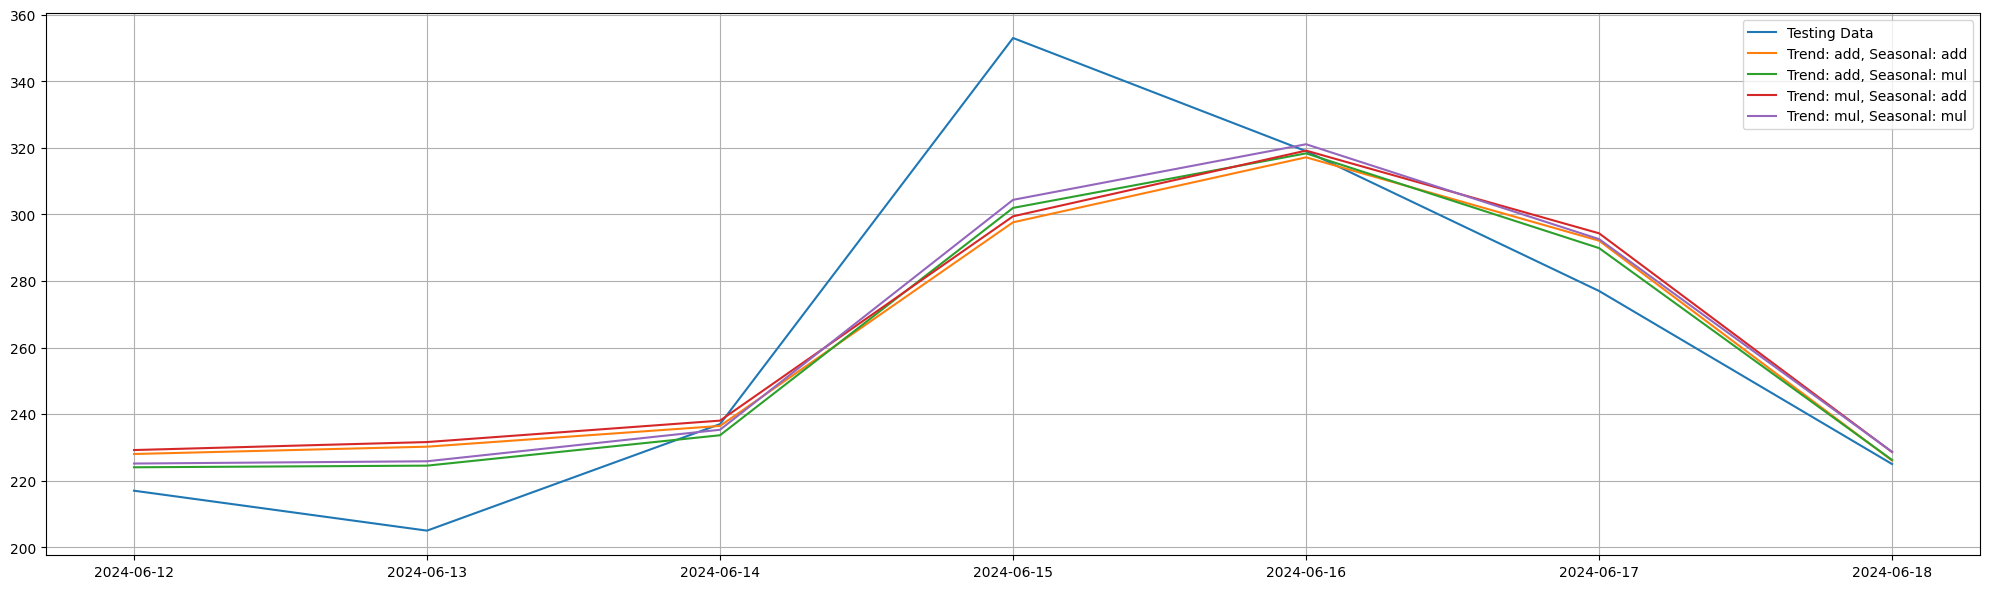

In [43]:
plt.figure(figsize=(20, 6)) 
plt.plot(test.index, test, label='Testing Data')
for key, forecast in forecasts.items():
    plt.plot(forecast.index, forecast.values, label=f'Trend: {key[0]}, Seasonal: {key[1]}')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
for key, forecast in forecasts.items():
    mape = mean_absolute_percentage_error(test, forecast) * 100
    print(f"Trend: {key[0]}, Seasonality: {key[1]}, Bias forecast: {mape:.2f}%")


Trend: add, Seasonality: add, Bias forecast: 5.69%
Trend: add, Seasonality: mul, Bias forecast: 4.86%
Trend: mul, Seasonality: add, Bias forecast: 6.02%
Trend: mul, Seasonality: mul, Bias forecast: 5.19%


### Autoarima analysis

In [ ]:
train = df.iloc[:-7]
test  = df.iloc[-7:]
len(train)

start=len(train)
end=start+len(test)-1
len(train)

In [ ]:
model_drunken_drivers = auto_arima(
    df["Drivers_under_the_influence_of_alcohol"],
    exogenous = df[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],
    start_p=0,
    start_q=0,
    max_p=5,
    max_q =5,
    seasonal=True,
    m=7,
    trace = True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)
model_drunken_drivers.summary()

In [ ]:
model_drunken_drivers = SARIMAX(train['Drivers_under_the_influence_of_alcohol'], exog=train[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']], 
                      order=(4,1,1), seasonal_order=(0,0,2,7)).fit() # Best model:  ARIMA(4,1,1)(0,0,2)[7]          
model_drunken_drivers.summary()

In [ ]:
diagnostics = model_drunken_drivers.plot_diagnostics(figsize=(12, 12))

In [ ]:
predictions_drunken_drivers=model_drunken_drivers.predict(start=start,exog=test[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],end=end,dynamic=False).rename('SARIMAX')
ax=test['Drivers_under_the_influence_of_alcohol'].plot(figsize=(14,5))
predictions_drunken_drivers.plot(legend=True)
for x in test.query('is_holiday==1').index:
    ax.axvline(x=x,color='r')

In [ ]:
mean_absolute_percentage_error(test['Drivers_under_the_influence_of_alcohol'],predictions_drunken_drivers)*100

### Machine Learning approach - Random Forest Regression

In [ ]:
features = [col for col in df.columns if col not in ['Drivers_under_the_influence_of_alcohol', 'is_holiday', 'Day_of_Week']]

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(train[features], train['Drivers_under_the_influence_of_alcohol'])
best_model = grid_search.best_estimator_
pred_drunken_drivers_rf = best_model.predict(test[features])

plt.figure(figsize=(14, 5))
test['Drivers_under_the_influence_of_alcohol'].plot(label='Actual drunken drivers')
pd.Series(pred_drunken_drivers_rf, index=test.index).plot(label='Random Forest Predictions', linestyle='--')
plt.legend()
plt.show()

mape_combined = mean_absolute_percentage_error(test['Drivers_under_the_influence_of_alcohol'], pred_drunken_drivers_rf) * 100
print(f'MAPE for Random Forest Predictions: {mape_combined:.2f}%')
print(f'Best hyperparameters: {grid_search.best_params_}')

Lags t-12

## Summary